In [408]:
from datetime import datetime
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
BASE_DATA_PATH = os.path.join("out_paper_v2")
OUTPUT_FOLDER = os.path.join("plots_paper_v2")
TIMES_IN_MS = False

def get_dataset_file(cloud_name, timestamp = "latest", data_path = BASE_DATA_PATH):
    # Get all CSV files in the folder
    csv_folder = os.path.join(data_path, cloud_name)
    csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
    df = None
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {csv_folder}")
    if timestamp == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),
            "%Y-%m-%d-%H:%M:%S"
        ))
        print(f"Loading latest file: {file}")
        df = pd.read_csv(file)
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            file_timestamp = filename.split('-')[1:]  # Split to get timestamp part
            file_timestamp = '-'.join(file_timestamp).replace('.csv', '')  # Rebuild timestamp string
            if timestamp == file_timestamp:
                print(f"Loading file: {file}")
                df = pd.read_csv(file)
        if df is None:
               FileNotFoundError(f"File with date '{timestamp}' not found in folder: {csv_folder}")
    # Convert times to milliseconds
    if TIMES_IN_MS:
        df['mean'] = df['mean'] * 1000
        df['stdev'] = df['stdev'] * 1000
        df['warmup_time'] = df['warmup_time'] * 1000
    return df

def read_multiple_datasets(clouds_datasets, data_path = BASE_DATA_PATH):
    dfs = {}
    for cloud, dataset in clouds_datasets.items():
        dfs[cloud] = get_dataset_file(cloud, "latest", data_path)
    return dfs

def output_fig(fig, filename):
    fig.savefig(os.path.join(OUTPUT_FOLDER, filename + ".pdf"), dpi=300, bbox_inches='tight')
    plt.close(fig)

In [409]:
import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    #'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'legend.title_fontsize': 14,  
    
    'axes.grid': True,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 100, 
    #'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',   # Edge color of the figure
})


In [410]:
def add_octree_types_legend(legend_handles, legend_labels, legend_title, fig, pos = (0.9, 0.97)):
    legend = fig.legend(
        legend_handles,
        legend_labels,
        title=legend_title,
        loc="upper right",
        bbox_to_anchor=pos,
        ncol=len(legend_handles),
        columnspacing=0.8,     # Reduce horizontal space between columns
        handletextpad=0.4,     # Reduce space between handle and text
        borderpad=0.5,         # Padding inside the legend box
        labelspacing=0.3,       # Reduce vertical space between labels
    )

In [411]:
# This dicts store information about the type parameters and possible combinations used in each visualization, 
# along with the palette of colors
TYPES_INFO_OCTREE_ENCODER = {
    "type_parameters":  ['octree', 'encoder'],
    "available_types": pd.DataFrame({
        'octree': ['LinearOctree', 'LinearOctree', 'Octree', 'Octree', 'Octree'],
        'encoder': ['HilbertEncoder3D', 'MortonEncoder3D', 'HilbertEncoder3D', 'MortonEncoder3D', 'Unencoded']
    }),

    "palette": {
        ('LinearOctree', 'HilbertEncoder3D'): '#1984c5',
        ('LinearOctree', 'MortonEncoder3D'): '#63bff0',
        ('Octree', 'HilbertEncoder3D'): '#c23728',
        ('Octree', 'MortonEncoder3D'): '#de6e56',
        ('Octree', 'Unencoded'): '#e1a692'
    },
    "display_name" : {
        ('LinearOctree', 'HilbertEncoder3D'): r'\texttt{loct\_hilb}',
        ('LinearOctree', 'MortonEncoder3D'): r'\texttt{loct\_mort}',
        ('Octree', 'HilbertEncoder3D'): r'\texttt{poct\_hilb}',
        ('Octree', 'MortonEncoder3D'): r'\texttt{poct\_mort}',
        ('Octree', 'Unencoded'): r'\texttt{poct\_unsorted}'
    }
}

In [412]:
DATA_SUBSET = os.path.join(BASE_DATA_PATH, "subset")
DATA_FULL = os.path.join(BASE_DATA_PATH, "full")
DATA_PARALLEL_SUBSET = os.path.join(BASE_DATA_PATH, "parallel_subset")
DATA_PARALLEL_FULL = os.path.join(BASE_DATA_PATH, "parallel_full")

In [413]:
# Multiple datasets
CLOUDS_DATASETS = {
                    "Lille_0": "Paris_Lille", 
                    "Paris_Luxembourg_6": "Paris_Lille",
                    "5080_54400": "DALES"
                }
RADII = {0.5, 1.0, 2.0, 3.0}
CLOUDS_DATASETS_HIGH_DENSITY = {
                    "bildstein_station1_xyz_intensity_rgb": "Semantic3D",
                    "sg27_station8_intensity_rgb": "Semantic3D",
                    "Speulderbos_2017_TLS": "Speulderbos"
                }
RADII_HIGH_DENSITY = {0.01, 0.05, 0.1}
ALL_CLOUDS = CLOUDS_DATASETS.copy()
ALL_CLOUDS.update(CLOUDS_DATASETS_HIGH_DENSITY)

In [414]:
def octree_runtime_comparison(cloud, dataset, data_path, operations , operation_name, show_warmup_time=False, types_info=TYPES_INFO_OCTREE_ENCODER):
    df = get_dataset_file(cloud, "latest", data_path)
    # Filter the dataset for the specified operation
    operation_df = df[df['operation'].isin(operations)]
    # Get unique radii and kernels
    radii = sorted(operation_df['radius'].unique())
    kernels = operation_df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(6,10),
                              gridspec_kw={'hspace': 0.6})
    if len(radii) == 1:
        axes = [axes]
   
    # Bar spacing parameters
    bar_width = 0.15
    group_width = bar_width * len(types_info["available_types"])
    group_gap = 0.2
   
    legend_handles, legend_labels = [], []
    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = operation_df[operation_df['radius'] == radius]
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = []
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'Kernel {kernel}\nSin datos')
                continue
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f"Kernel {kernel}\n" + f"$avg\\_size = {avg_total:.0f}$")
           
            # Finally, iterate through each of the octree implementations identified by the (octree, encoder, point_type) tuple
            for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
                # Extract parameters dynamically from the row
                key = tuple(params[col] for col in types_info["type_parameters"])
                octree_data = kernel_data[
                    (kernel_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]
                if octree_data.empty:
                    continue
                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                warmup_times = octree_data['warmup_time'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                
                # Main execution time bar
                bar = ax.bar(x_pos, means[0], bar_width,
                             color=types_info["palette"][key])
                
                # Warmup time bar (if enabled)
                if show_warmup_time:
                    ax.bar(x_pos, warmup_times[0], bar_width, 
                           color="none", 
                           edgecolor='black', alpha = 0.5,
                           zorder=-2)  # Ensure it's drawn on top
                
                ax.errorbar(x_pos, means[0], stdevs[0],
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
                formatted_label = types_info["display_name"][key]
                if radius_idx == 0 and formatted_label not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        if len(kernel_labels) < 4:
            ax.set_xticklabels(kernel_labels, fontsize=12)
        else:
            ax.set_xticklabels(kernel_labels, fontsize=8)
       
        ax.text(0, 1.15, f'$r = {radius}$',
                transform=ax.transAxes,
                fontsize=12,
                va='top', ha='left')
       
        ax.set_ylabel(f"Tiempo total {'(ms)' if TIMES_IN_MS else '(s)'}")
   
    add_octree_types_legend(legend_handles, legend_labels, "Combinación Octree+SFC", fig)
    return fig

In [415]:
import seaborn as sns
def octree_parallelization(cloud, dataset, encoder, kernel, octree, data_path, annotated=False):
    df = get_dataset_file(cloud, "latest", data_path)
    df = df[(df["octree"] == octree) & (df["encoder"] == encoder) & (df['kernel'] == kernel)][["num_searches", "repeats", "npoints", "radius", "mean", "openmp_threads"]]
    # Extract ntreads=1 baseline
    baseline = df[df["openmp_threads"] == 1].set_index("radius")["mean"]
    # Merge it on the df
    df = df.merge(baseline.rename("T1"), on="radius")
    # Compute the efficiency as (time 1 thread) / (time n threads * n)
    df["efficiency"] = df["T1"] / (df["openmp_threads"] * df["mean"])
    # Pivot and get the efficiency matrix
    efficiency_matrix = df.pivot(index="radius", columns="openmp_threads", values="efficiency")
    figsize = (7, 2.5)
    fig, ax = plt.subplots(figsize=figsize, gridspec_kw={'top': 0.75})
    heatmap = sns.heatmap(efficiency_matrix, cmap="viridis", annot=annotated, fmt=".2f", linewidths=0, 
                vmin=0, vmax=1, 
                cbar_kws={'label': 'Eficiencia'}, # Add the shrink parameter
                annot_kws={"size": 10},
                ax=ax)    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_ylabel('Eficiencia', fontsize=15)
    plt.subplots_adjust(bottom=0.05)
    # Labels and title
    ax.set_xlabel("Número de hilos", fontsize=15)
    ax.set_ylabel("Radio de búsqueda", fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    return fig

In [416]:
import scipy.stats as stats

def plot_avg_result_sizes_log(clouds_datasets, kernel, operations, operation_name, data_path, types_info=TYPES_INFO_OCTREE_ENCODER):
    dfs = read_multiple_datasets(clouds_datasets, data_path)
    fig, ax = plt.subplots(figsize=(6, 6))
    legend_handles, legend_labels = [], []
    
    for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
        key = tuple(params[col] for col in types_info["type_parameters"])
        avg_sizes, runtimes = [], []
        
        for df_name, df in dfs.items():
            filtered_df = []
            if kernel == "all":
                filtered_df = df[(df['operation'].isin(operations))]
            else:
                filtered_df = df[(df['kernel'] == kernel) & (df['operation'].isin(operations))]
            if filtered_df.empty:
                continue
            octree_data = filtered_df[
                (filtered_df[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
            ]
            if octree_data.empty:
                continue
            avg_sizes.extend(octree_data['avg_result_size'].tolist())
            runtimes.extend(octree_data['mean'].tolist())

        if avg_sizes and runtimes:
            scatter = ax.scatter(avg_sizes, runtimes, color=types_info["palette"][key], s=20)
            legend_handles.append(scatter)
            legend_labels.append(types_info["display_name"][key])
            # linear regression line
            # slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(avg_sizes), np.log(runtimes))
            # regression_line = np.exp(intercept + slope * np.log(np.array(avg_sizes)))
            # ax.plot(avg_sizes, regression_line, color=types_info["palette"][key], linestyle='dashed', linewidth=1)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel(r"$avg\_size$", fontsize=16)
    ax.set_ylabel(f"Tiempo total {'(ms)' if TIMES_IN_MS else '(s)'}", fontsize=16)
        
    # Add legend and titles
    add_octree_types_legend(legend_handles, legend_labels, "Combinación Octree+SFC", fig, (0.905, 0.98))
    return fig


Loading latest file: out_paper_v2/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-04-02-12:46:59.csv


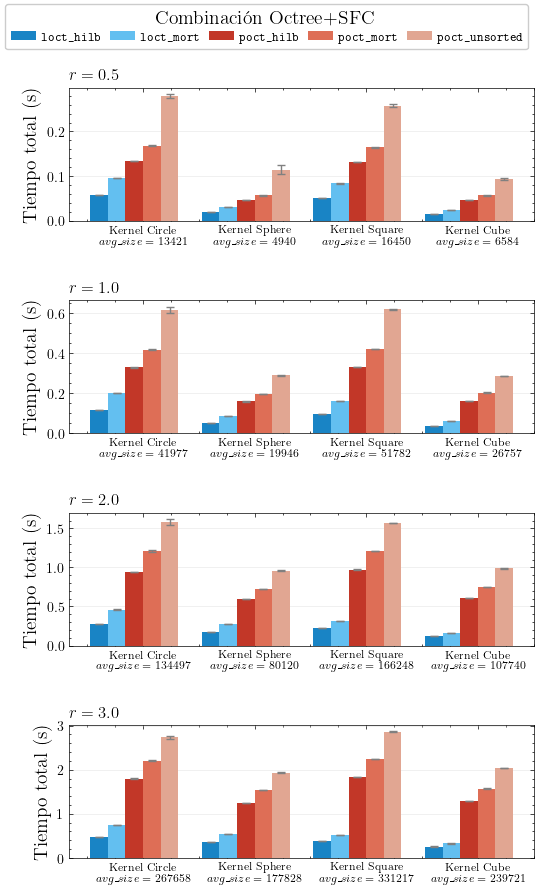

In [417]:
# Paris_Luxembourg_6 SUBSETS
fig = octree_runtime_comparison("Paris_Luxembourg_6", "Paris_Lille", DATA_SUBSET, ['neighSearch'], 'Neighbor search')
output_fig(fig, "paris_luxembourg_6_subsets")
display(fig)

Loading latest file: out_paper_v2/full/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-04-02-14:50:21.csv


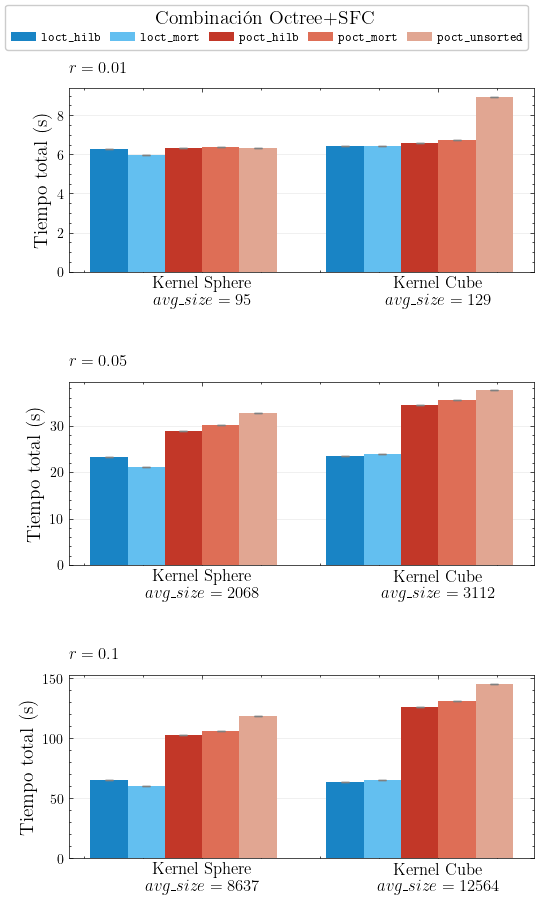

In [418]:
# bildstein_station1 FULL
fig = octree_runtime_comparison("bildstein_station1_xyz_intensity_rgb", "Semantic3D", DATA_FULL, ['neighSearch'], 'Neighbor search')
output_fig(fig, "bilstein_station1_full")
display(fig)

Loading latest file: out_paper_v2/subset/Lille_0/Lille_0-2025-04-02-12:44:53.csv
Loading latest file: out_paper_v2/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-04-02-12:46:59.csv
Loading latest file: out_paper_v2/subset/5080_54400/5080_54400-2025-04-02-12:46:27.csv
Loading latest file: out_paper_v2/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-04-02-12:50:29.csv
Loading latest file: out_paper_v2/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-04-02-12:55:01.csv
Loading latest file: out_paper_v2/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-04-02-14:04:42.csv


/tmp/ipykernel_21165/2198333688.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_21165/2198333688.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


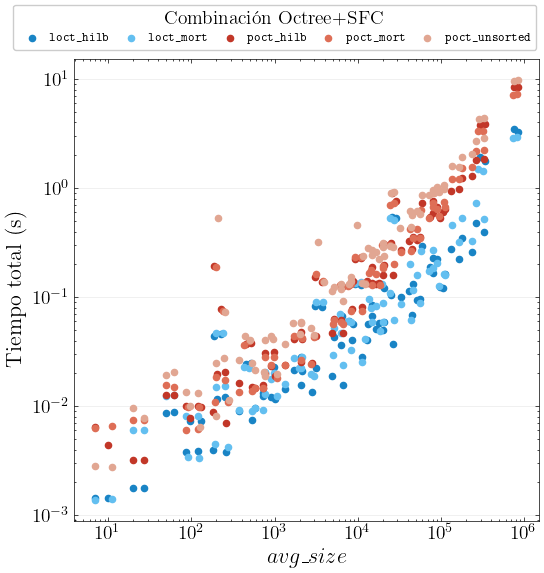

In [419]:
# log-log SUBSETS
fig = plot_avg_result_sizes_log(ALL_CLOUDS, "all", ["neighSearch"], "Neighbors search", DATA_SUBSET)
output_fig(fig, "loglog_subsets")
display(fig)

Loading latest file: out_paper_v2/parallel_subset/Lille_0/Lille_0-2025-04-02-23:42:34.csv


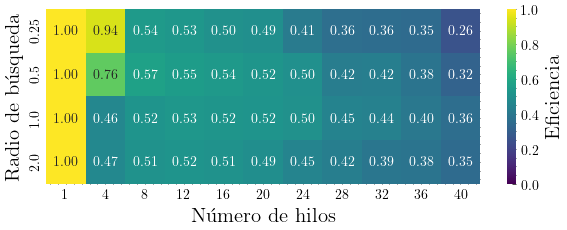

Loading latest file: out_paper_v2/parallel_subset/Lille_0/Lille_0-2025-04-02-23:42:34.csv


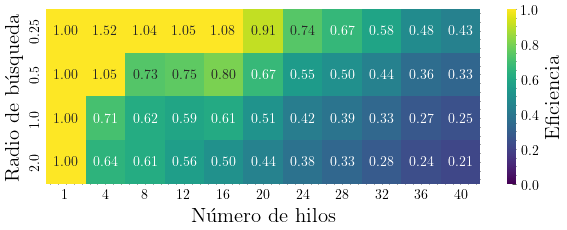

Loading latest file: out_paper_v2/parallel_subset/Lille_0/Lille_0-2025-04-02-23:42:34.csv


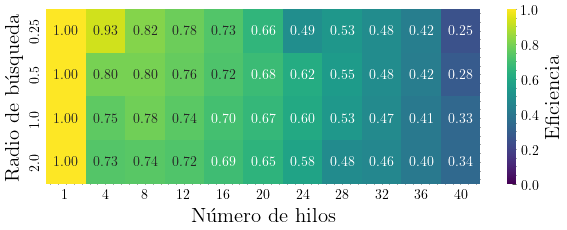

In [420]:
# parallel SUBSETS
fig = octree_parallelization("Lille_0", "Paris_Lille", "Unencoded", "Sphere", "Octree", DATA_PARALLEL_SUBSET, True)
output_fig(fig, "lille_0_parallel_subset_poct_unsorted")
display(fig)

fig = octree_parallelization("Lille_0", "Paris_Lille", "HilbertEncoder3D", "Sphere", "Octree", DATA_PARALLEL_SUBSET, True)
output_fig(fig, "lille_0_parallel_subset_poct_hilb")
display(fig)

fig = octree_parallelization("Lille_0", "Paris_Lille", "HilbertEncoder3D", "Sphere", "LinearOctree", DATA_PARALLEL_SUBSET, True)
output_fig(fig, "lille_0_parallel_subset_loct_hilb")
display(fig)

In [421]:
# parallel FULL
fig = octree_parallelization("Lille_0", "Paris_Lille", "Unencoded", "Sphere", "Octree", DATA_PARALLEL_FULL, True)
output_fig(fig, "lille_0_parallel_full_poct_unsorted")
display(fig)

fig = octree_parallelization("Lille_0", "Paris_Lille", "HilbertEncoder3D", "Sphere", "Octree", DATA_PARALLEL_FULL, True)
output_fig(fig, "lille_0_parallel_full_poct_hilb")
display(fig)

fig = octree_parallelization("Lille_0", "Paris_Lille", "HilbertEncoder3D", "Sphere", "LinearOctree", DATA_PARALLEL_FULL, True)
output_fig(fig, "lille_0_parallel_full_loct_hilb")
display(fig)

Loading latest file: out_paper_v2/parallel_full/Lille_0/Lille_0-2025-04-03-10:43:45.csv


EmptyDataError: No columns to parse from file